# NFL Outcome Prediction Analysis

## Table of Contents
1. [Cleaning & Initial Analysis](#cleaning--initial-analysis)
2. [Home Field Advantage](#home-field-advantage)
3. [Fantasy Points Analysis](#fantasy-points-analysis)

In [116]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Cleaning & Initial Analysis

In [ ]:
#nflcombine.csv has game data from 2019-2022.
nfl_data = pd.read_csv("nflcombine.csv")
nfl_data = nfl_data.drop(columns=['Unnamed: 0'])
nfl_data.head()

,Opp,Tm,Opp.1,1stD,TotYd,PassY,RushY,TO,1stD.1,TotYd.1,PassY.1,RushY.1,TO.1,Offense,Defense,Sp. Tms,Home_team,Year,Winner
0,Tampa Bay Buccaneers,31.0,17.0,17.0,256.0,158.0,98.0,2.0,21.0,295.0,174.0,121.0,4.0,-7.51,19.12,1.10,San Francisco 49ers,2019,San Francisco 49ers
1,Cincinnati Bengals,41.0,17.0,27.0,571.0,312.0,259.0,1.0,14.0,316.0,291.0,25.0,1.0,27.34,1.14,-6.64,San Francisco 49ers,2019,San Francisco 49ers
2,Pittsburgh Steelers,24.0,20.0,26.0,436.0,268.0,168.0,5.0,11.0,239.0,160.0,79.0,2.0,-3.72,10.20,0.12,San Francisco 49ers,2019,San Francisco 49ers
3,Los Angeles Rams,20.0,7.0,22.0,331.0,232.0,99.0,2.0,10.0,157.0,48.0,109.0,1.0,-3.54,25.23,-5.01,San Francisco 49ers,2019,San Francisco 49ers
4,Washington Redskins,9.0,0.0,17.0,283.0,146.0,137.0,1.0,10.0,154.0,50.0,104.0,1.0,-1.99,14.12,-0.61,San Francisco 49ers,2019,San Francisco 49ers


In [3]:
nfl_data.describe()

,Tm,Opp.1,1stD,TotYd,PassY,RushY,TO,1stD.1,TotYd.1,PassY.1,RushY.1,TO.1,Offense,Defense,Sp. Tms,Year
count,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000
mean,23.225698,23.027933,20.501676,348.048045,231.830168,116.217877,1.773184,20.456983,346.213408,230.554190,115.659218,1.777654,2.345296,-2.108760,-0.030872,2020.167598
std,9.855353,9.891712,4.985858,85.873697,79.250306,51.796933,1.000535,5.036344,86.111474,79.536163,51.477706,1.007107,11.939509,12.013528,5.010320,0.980150
min,0.000000,0.000000,6.000000,105.000000,-6.000000,3.000000,1.000000,6.000000,105.000000,-6.000000,3.000000,1.000000,-35.650000,-40.690000,-17.390000,2019.000000
25%,17.000000,17.000000,17.000000,285.500000,175.000000,78.000000,1.000000,17.000000,283.000000,174.000000,78.000000,1.000000,-4.800000,-9.875000,-3.410000,2019.000000
50%,23.000000,23.000000,21.000000,354.000000,229.000000,109.000000,1.000000,21.000000,352.000000,228.000000,108.000000,1.000000,3.210000,-2.830000,-0.060000,2020.000000
75%,30.000000,30.000000,24.000000,405.500000,282.500000,145.000000,2.000000,24.000000,403.500000,280.500000,144.000000,2.000000,9.930000,5.310000,3.355000,2021.000000
max,56.000000,56.000000,36.000000,592.000000,490.000000,404.000000,7.000000,36.000000,592.000000,490.000000,404.000000,7.000000,40.690000,35.650000,17.390000,2022.000000


In [4]:
nfl_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 895 entries, 0 to 894
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Opp        895 non-null    object 
 1   Tm         895 non-null    float64
 2   Opp.1      895 non-null    float64
 3   1stD       895 non-null    float64
 4   TotYd      895 non-null    float64
 5   PassY      895 non-null    float64
 6   RushY      895 non-null    float64
 7   TO         895 non-null    float64
 8   1stD.1     895 non-null    float64
 9   TotYd.1    895 non-null    float64
 10  PassY.1    895 non-null    float64
 11  RushY.1    895 non-null    float64
 12  TO.1       895 non-null    float64
 13  Offense    895 non-null    float64
 14  Defense    895 non-null    float64
 15  Sp. Tms    895 non-null    float64
 16  Home_team  895 non-null    object 
 17  Year       895 non-null    int64  
 18  Winner     891 non-null    object 
dtypes: float64(15), int64(1), object(3)
memory usage: 

The following aggregates multiple datasets into one about rookie stats and their combine stats

In [41]:

def dataFrameCreation(year, pos):
    """
    Creates a merged DataFrame containing rookie player stats and combine results for a given year and position.

    Parameters:
        year (int): The rookie year to filter players by.
        pos (str): The position to filter players by (e.g., "WR" for wide receiver).

    Returns:
        pd.DataFrame: Merged DataFrame of rookies at the specified position and year, including combine stats.
                      
    """
        
    players = pd.read_csv("fullplayersdataset.csv") #DataFrame with most if not every single NFL Player
    combine = pd.read_csv("combine.csv") #Combine Stats of players since 2000s
    rookies = players[players["rookie_year"] == year] 
    rookies.rename(columns={"display_name": "player_name"}, inplace=True)
    playerStats = pd.read_csv(f"PlayerStatsNFLVerseData/player_stats_season_{year}.csv")
    playerStats = playerStats.drop(columns=['player_name', 'player_id', "headshot_url", "recent_team", "season_type"], axis=1)
    playerStats.rename(columns={"player_display_name": "player_name"}, inplace=True)
    merged = pd.merge(rookies, playerStats, on='player_name', how='left')
    merged = merged.drop(columns=["current_team_id", "esb_id", "gsis_it_id", "uniform_number", "headshot", "smart_id"])
    merged = merged.dropna(subset=["season"])
    posD = merged[merged["position_x"] == pos]
    newPos = pd.merge(posD, combine, on="player_name", how = "left")
    for col in ["bench", "forty", "vertical", "shuttle", "broad_jump", "cone"]:
        newPos[f"{col}_missing"] = newPos[col].isnull().astype(int)
    
    return newPos




In [42]:
pd.options.mode.chained_assignment = None  


rookieWrs2019 = dataFrameCreation(2019, "WR")
rookieWrs2020 = dataFrameCreation(2020, "WR")
rookieWrs2021 = dataFrameCreation(2021, "WR")
rookieWrs2022 = dataFrameCreation(2022, "WR")
rookieWrs2023 = dataFrameCreation(2023, "WR")
rookieWrs2024 = dataFrameCreation(2024, "WR")


allWrs = pd.concat(
    [rookieWrs2019, rookieWrs2020, rookieWrs2021, rookieWrs2022, rookieWrs2023, rookieWrs2024],
    ignore_index=True
)

allWrs.head()


,college_conference,college_name,player_name,draft_club,draft_number,draftround,entry_year,first_name,football_name,gsis_id,...,vertical,broad_jump,cone,shuttle,bench_missing,forty_missing,vertical_missing,shuttle_missing,broad_jump_missing,cone_missing
0,Southeastern Conference,Mississippi,A.J. Brown,TEN,51.0,2.0,2019.0,Arthur,A.J.,00-0035676,...,36.5,120.0,NaN,NaN,0,0,0,1,0,1
1,Southeastern Conference,Mississippi,A.J. Brown,TEN,51.0,2.0,2019.0,Arthur,A.J.,00-0035676,...,36.5,120.0,NaN,NaN,0,0,0,1,0,1
2,Southeastern Conference,Mississippi,A.J. Brown,TEN,51.0,2.0,2019.0,Arthur,A.J.,00-0035676,...,36.5,120.0,NaN,NaN,0,0,0,1,0,1
3,Ohio Valley Conference,Eastern Illinois,Alexander Hollins,NaN,NaN,NaN,2019.0,Alexander,Alexander,00-0035104,...,NaN,NaN,NaN,NaN,1,1,1,1,1,1
4,Ohio Valley Conference,Eastern Illinois,Alexander Hollins,NaN,NaN,NaN,2019.0,Alexander,Alexander,00-0035104,...,NaN,NaN,NaN,NaN,1,1,1,1,1,1


In [7]:
allWrs = allWrs.drop_duplicates(keep="first")
allWrs.isnull().sum()

college_conference     0
college_name           0
player_name            0
draft_club             8
draft_number           8
                      ..
bench                 56
vertical               1
broad_jump             6
cone                  17
shuttle                0
Length: 89, dtype: int64

There are null values in this dataframe, however most of the null values make sense. For example, usually most people do not have a suffix in their name. There are a lot of null values for combine stats, however. 

<Axes: xlabel='fantasy_points_ppr', ylabel='Count'>

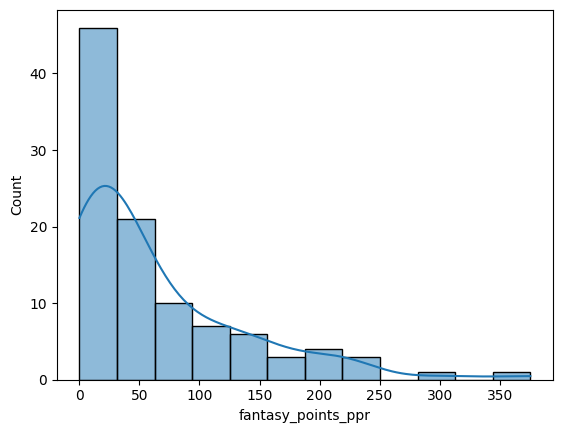

In [8]:

fig, axes=plt.subplots()
sns.histplot(allWrs["fantasy_points_ppr"], kde=True)

## Correlation Between Variables

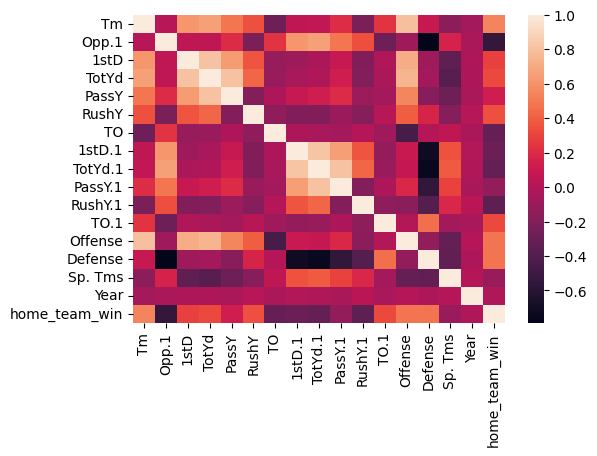

In [9]:
nfl_data["home_team_win"] = nfl_data["Home_team"] == nfl_data["Winner"]
nfl_data["home_team_win"] = nfl_data["home_team_win"].astype(int)
int_columns = nfl_data.select_dtypes(include=['int64', 'int32', 'int', 'double', 'float'])
plt.figure(figsize=(6,4))
sns.heatmap(int_columns.corr())
plt.show()

<span style="font-size:14px"> Looking at the heatmap of the correlation, it demonstrates that the ranking of the teams playing in the game matter a lot in determining who will win the game. Additionally, a game time statistic that is negatively correlated is turnovers.

# Home Field Advantage

## Does Home Field Advantage Actually Help Win Games?

**I will conduct a 1 Proportion Z-Test to determine whether the chance of the home team winning is greater than 50% or not with a significance level of 0.05**


**Ho** = The proportion of home team wins is equal to 50%

**Ha** = The proportion of home team wins is greater than 50%

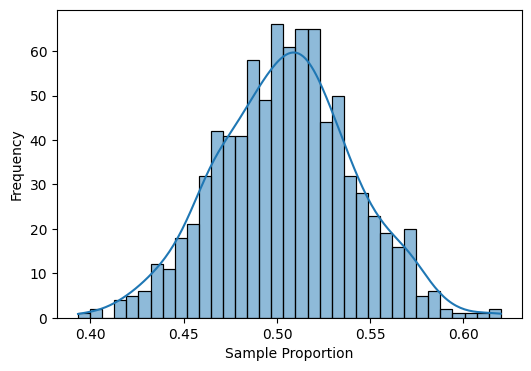

In [10]:
sample_size = 150
num_samples = 850

sample_proportions = []
for i in range(num_samples):
    sample = nfl_data.sample(n=sample_size, replace=False)
    proportion = (sample["Home_team"] == sample["Winner"]).mean()
    sample_proportions.append(proportion)

plt.figure(figsize=(6,4))
sns.histplot(sample_proportions, bins=35, kde=True)
plt.xlabel("Sample Proportion")
plt.ylabel("Frequency")
plt.show()

Since our sample size (150) is big enough for the central limit theorem to apply, we are able to conduct the test

In [11]:
from statsmodels.stats.proportion import proportions_ztest


sample = nfl_data.sample(n=sample_size, replace=False, random_state=42)
homeTeamWin = sample[sample["Home_team"] == sample["Winner"]]
zStatistic, pValue = proportions_ztest(homeTeamWin.shape[0], sample.shape[0], 0.5, alternative="larger", prop_var=False)

print(zStatistic, pValue)

1.1481067942068246 0.1254622398694959


Since the p-value is greater than α (in our example, p = 0.12 > 0.05), we fail to reject the null hypothesis. This means we do not have evidence to conclude that a home field advantage exists.

While this test isn't perfect (an injury in one game may affect another game meaning each game isn't independent), it provides an overview of the general trend in home team performance. Despite a potential violation of independence, the 1-proportion z-test offers a useful starting point for assessing whether home field advantage exists in the data. Further analysis will need to be conducted in order to eliminate confounding variables.

## Does Home Field Advantage Affect Turnovers?

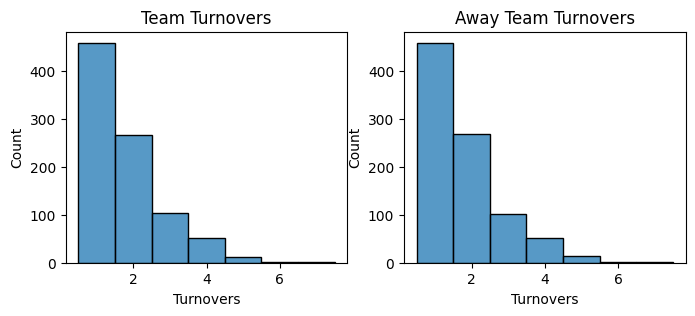

Home Team Turnovers Mean: 1.7731843575418995
Away Team Turnovers Mean: 1.7776536312849163


In [12]:
fig, axes = plt.subplots(1, 2, figsize=(8,3))
sns.histplot(nfl_data["TO"], ax=axes[0], discrete=True)
axes[0].set_title("Team Turnovers")
axes[0].set_xlabel("Turnovers")
sns.histplot(nfl_data["TO.1"], ax=axes[1], discrete=True)
axes[1].set_title("Away Team Turnovers")
axes[1].set_xlabel("Turnovers")
plt.show()


print(f"Home Team Turnovers Mean: {nfl_data["TO"].mean()}")
print(f"Away Team Turnovers Mean: {nfl_data["TO.1"].mean()}")



**A Two Sample One Sided T-Test will be used to determine whether there is a significant difference between home team turnovers and away team turnovers**

**H₀:** The mean turnovers for home teams is equal to the mean turnovers for away teams (μ₁ = μ₂)

**H₁:** The mean turnovers for home teams is less than the mean turnovers for away teams (μ₁ < μ₂)

In [13]:
turnoverSampleHome = nfl_data.sample(250, replace=False, random_state=100)
remaining = nfl_data.drop(turnoverSampleHome.index)
turnoverSampleAway = remaining.sample(250, replace=False, random_state=50)

mean1 = turnoverSampleHome["TO"].mean()
mean2 = turnoverSampleAway["TO.1"].mean()
print(mean1)
print(mean2)
tStatistic, pValue = stats.ttest_ind(turnoverSampleHome["TO"], turnoverSampleAway["TO.1"], equal_var=False, alternative="less")

print(f"T-Statistic: {tStatistic}")
print(f"p-Value: {pValue}")

1.744
1.792
T-Statistic: -0.5362257839934658
p-Value: 0.29602115758361924


The p-value returned by the t-test is 59%, which is much higher than the significance level of 5%. This means that we do not have sufficient evidence to reject the null hypothesis and say that there is a difference between home team and away team turnovers. While this test is not perfect (1 game may affect another game), it is a starting point to identify trends in what playing in a team's home-field affects.

## Does being at home versus away shift the strategy from passing to rushing or vice versa?

Two new features will be created, passing yards minus rushing yards for the home team, and passing yards minus rushing yards for the away team. 

Text(0.5, 1.0, 'Away Team Passing - Rushing Yards')

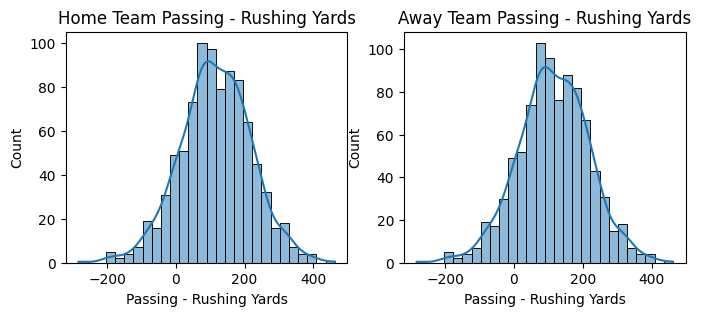

In [14]:
nfl_data["passingvrushing"] = nfl_data["PassY"] - nfl_data["RushY"]
nfl_data["passingvrushing.1"] = nfl_data["PassY.1"] - nfl_data["RushY.1"]


fig, axes = plt.subplots(1, 2, figsize=(8, 3))
sns.histplot(nfl_data["passingvrushing"], ax=axes[0], kde = True)
axes[0].set_xlabel("Passing - Rushing Yards")
axes[0].set_title("Home Team Passing - Rushing Yards")
sns.histplot(nfl_data["passingvrushing.1"], ax=axes[1], kde = True)
axes[1].set_xlabel("Passing - Rushing Yards")
axes[1].set_title("Away Team Passing - Rushing Yards")




**A Two Sample Two Sided T-Test will be used to determine whether there is a significant difference between the tendency to pass versus rush for home teams and away teams**

**Ho:** The mean value of passing yards minus rushing yards for home teams is equal to that for away teams (μ₁ = μ₂)

**Ha:** The mean value of passing yards minus rushing yards for home teams is different from that for away teams (μ₁ ≠ μ₂)

In [15]:
homeTeams = nfl_data.sample(250, random_state=48239482)
remaining = nfl_data.drop(homeTeams.index)
awayTeams = remaining.sample(250, random_state=4239482)

tStatistic, pValue = stats.ttest_ind(homeTeams["passingvrushing"], awayTeams["passingvrushing.1"], equal_var=False)



print(f"T-Statistic: {tStatistic}")
print(f"p-Value: {pValue}")

T-Statistic: -0.09771053268807309
p-Value: 0.922201491958681


The p-value returned by the t-test is 92%, which is much higher than the significance level of 5%. This means that we do not have sufficient evidence to reject the null hypothesis and say that there is a difference between the tendency to pass versus rush for home teams and away teams.

## Comparing different models for prediction of who won an NFL Game

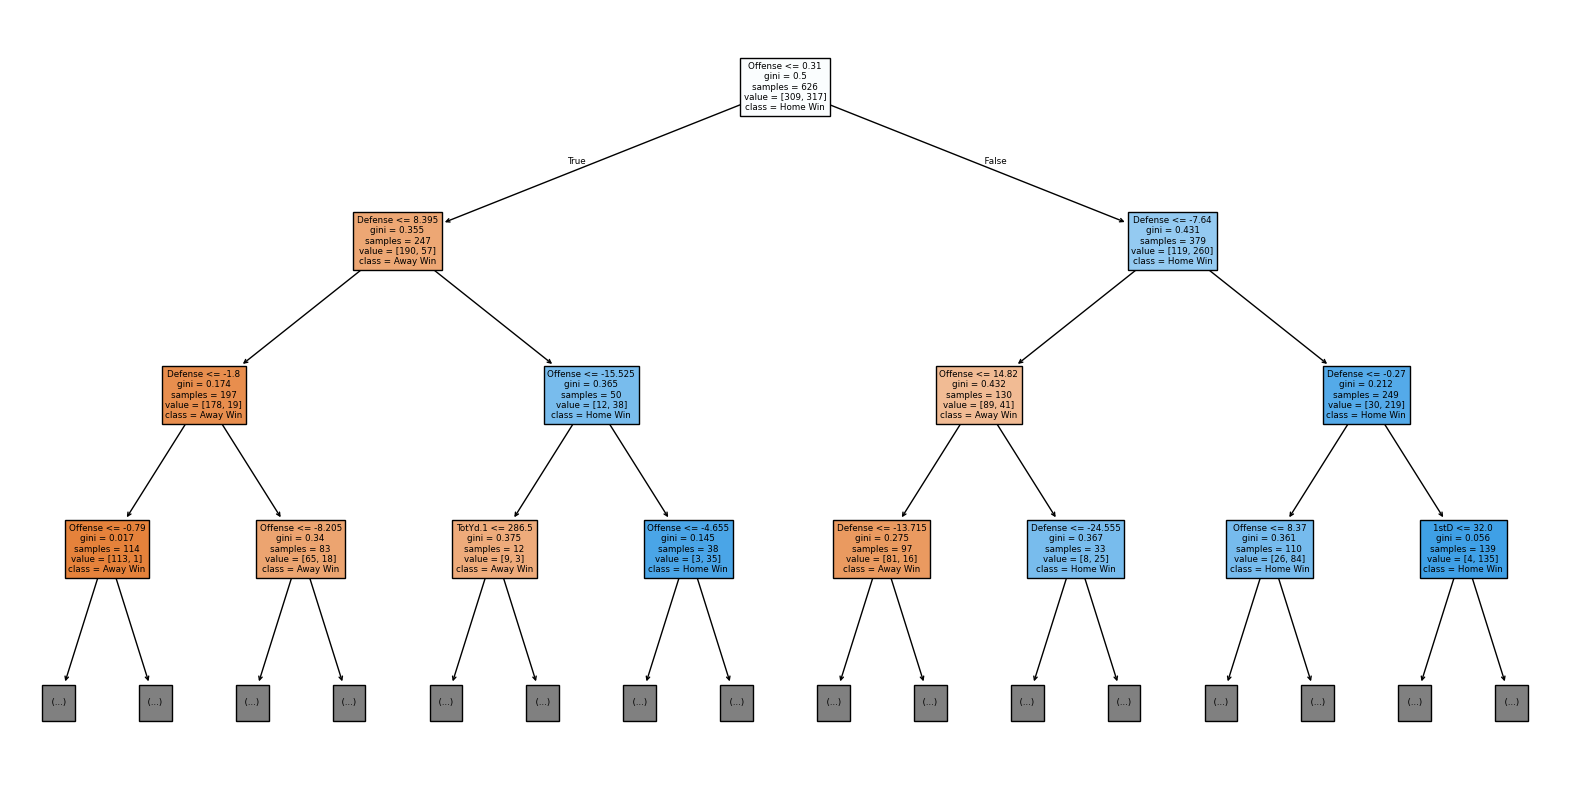

Text(0.5, 1.0, 'XGBoost')

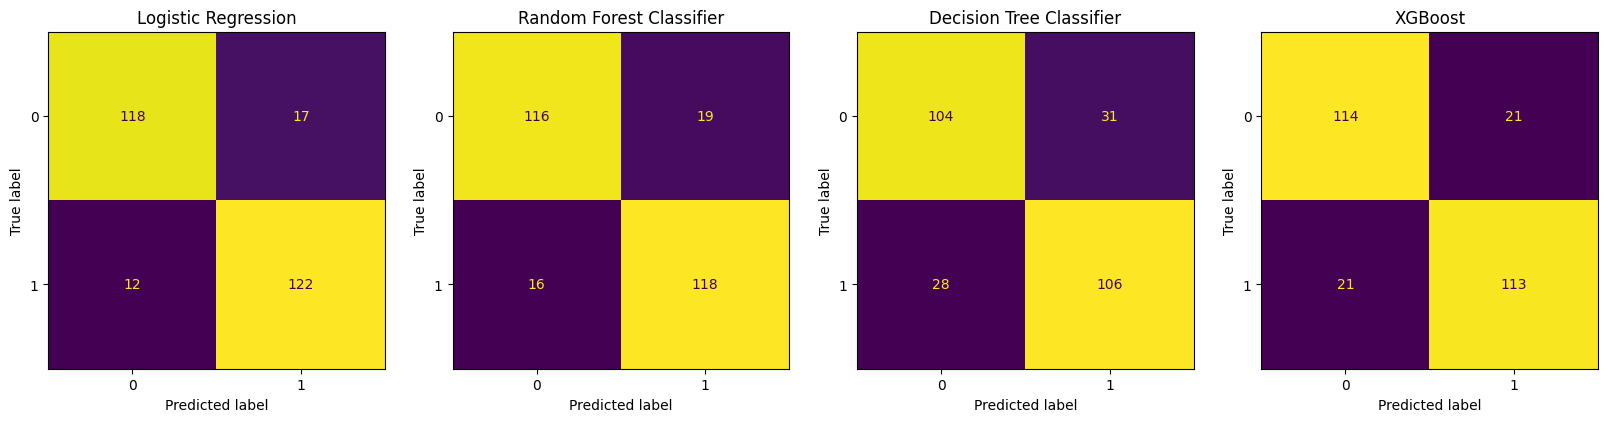

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

predictors = ["1stD", "TotYd", "PassY", "RushY", "TO", "TotYd.1", "TO.1", "Offense", "Defense"]
X = nfl_data[predictors]
y = nfl_data["home_team_win"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

model = LogisticRegression(max_iter=800)

model.fit(X_train, y_train)

predLR = model.predict(X_test)
cm = confusion_matrix(y_test, predLR)
dispLR = ConfusionMatrixDisplay(cm, display_labels=model.classes_)


rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
predRFC = rfc.predict(X_test)
cm = confusion_matrix(y_test, predRFC)
dispRFC = ConfusionMatrixDisplay(cm, display_labels=rfc.classes_)


dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
predDTC = dtc.predict(X_test)
plt.figure(figsize=(20, 10))
plot_tree(dtc, feature_names=X.columns, class_names=['Away Win', 'Home Win'], filled=True, max_depth=3)
plt.show()
cm = confusion_matrix(y_test, predDTC)
dispDTC = ConfusionMatrixDisplay(cm, display_labels=dtc.classes_)


xgb = XGBClassifier()
xgb.fit(X_train, y_train)
predXGB = xgb.predict(X_test)
cm = confusion_matrix(y_test, predXGB)
dispXGB = ConfusionMatrixDisplay(cm, display_labels=xgb.classes_)

fig, axes = plt.subplots(1, 4, figsize=(20, 6))

dispLR.plot(ax=axes[0], colorbar=False)
axes[0].set_title("Logistic Regression")
dispRFC.plot(ax=axes[1], colorbar=False)
axes[1].set_title("Random Forest Classifier")
dispDTC.plot(ax=axes[2], colorbar=False)
axes[2].set_title("Decision Tree Classifier")
dispXGB.plot(ax=axes[3], colorbar=False)
axes[3].set_title("XGBoost")

Analyzing the confusion matrices, Logistic Regession performs the best at determining who won a home game.

Additionally, in the decision tree, the main variables being used is Offensive and Defensive rankings for predicting.

In [54]:
print(nfl_data["Offense"].corr(nfl_data["home_team_win"]))
print(nfl_data["Defense"].corr(nfl_data["home_team_win"]))

0.4823571260802421
0.47902581084366896


Clearly there is a correlation between this Offensive/Defensive Statistic and if the home team won.

## What if we removed those statistics?

It would only leave game-time statistics to predict.

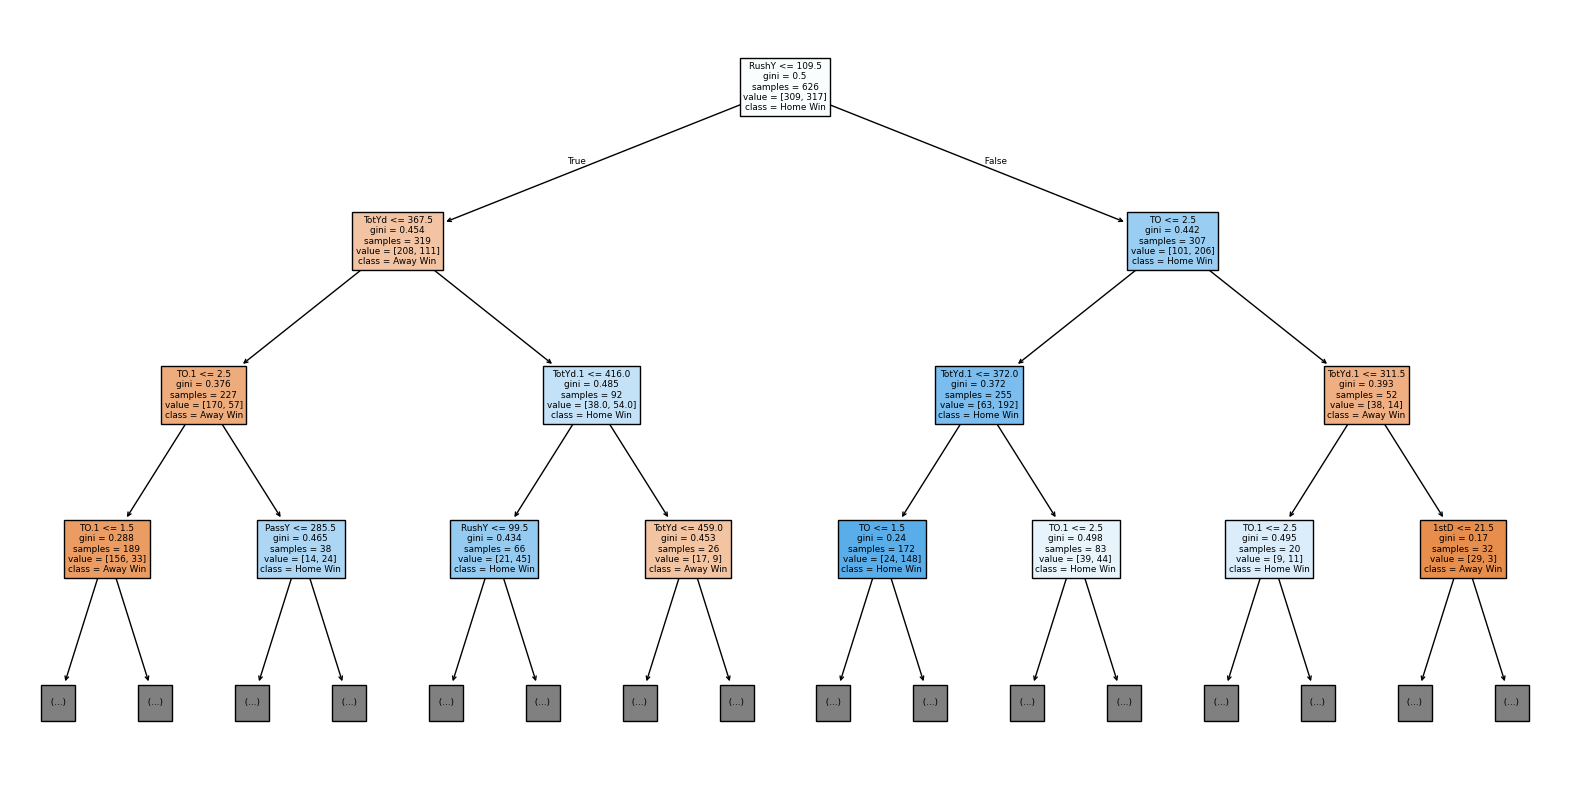

Text(0.5, 1.0, 'XGBoost')

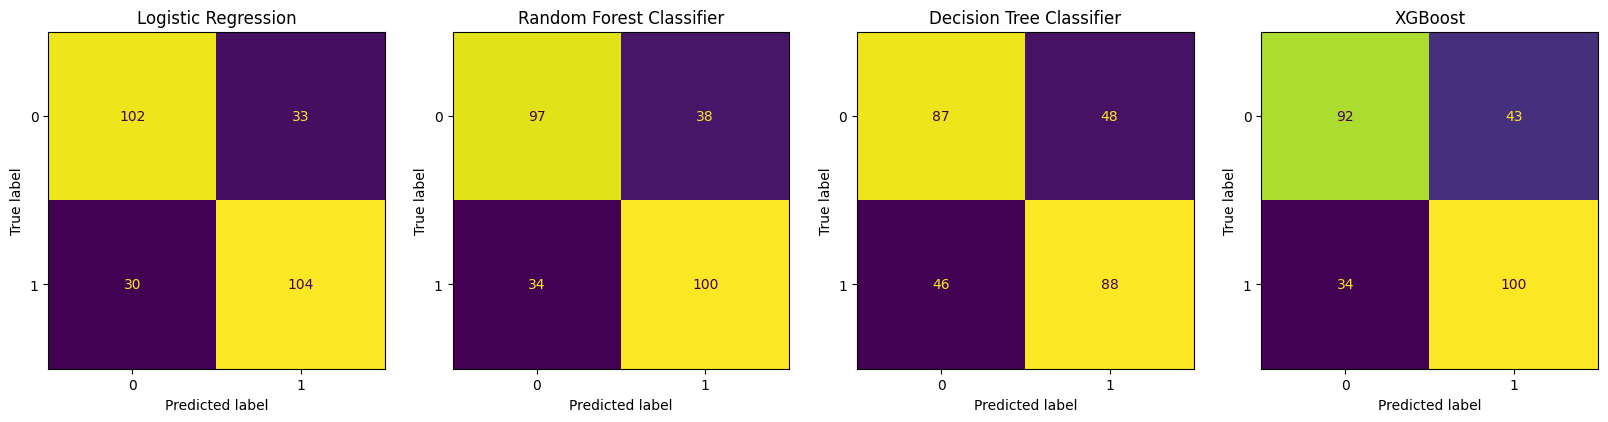

In [59]:
predictors = ["1stD", "TotYd", "PassY", "RushY", "TO", "TotYd.1", "TO.1"]
X = nfl_data[predictors]
y = nfl_data["home_team_win"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

model = LogisticRegression(max_iter=800)

model.fit(X_train, y_train)

predLR = model.predict(X_test)
cm = confusion_matrix(y_test, predLR)
dispLR = ConfusionMatrixDisplay(cm, display_labels=model.classes_)


rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
predRFC = rfc.predict(X_test)
cm = confusion_matrix(y_test, predRFC)
dispRFC = ConfusionMatrixDisplay(cm, display_labels=rfc.classes_)


dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
predDTC = dtc.predict(X_test)
plt.figure(figsize=(20, 10))
plot_tree(dtc, feature_names=X.columns, class_names=['Away Win', 'Home Win'], filled=True, max_depth=3)
plt.show()
cm = confusion_matrix(y_test, predDTC)
dispDTC = ConfusionMatrixDisplay(cm, display_labels=dtc.classes_)


xgb = XGBClassifier()
xgb.fit(X_train, y_train)
predXGB = xgb.predict(X_test)
cm = confusion_matrix(y_test, predXGB)
dispXGB = ConfusionMatrixDisplay(cm, display_labels=xgb.classes_)

fig, axes = plt.subplots(1, 4, figsize=(20, 6))

dispLR.plot(ax=axes[0], colorbar=False)
axes[0].set_title("Logistic Regression")
dispRFC.plot(ax=axes[1], colorbar=False)
axes[1].set_title("Random Forest Classifier")
dispDTC.plot(ax=axes[2], colorbar=False)
axes[2].set_title("Decision Tree Classifier")
dispXGB.plot(ax=axes[3], colorbar=False)
axes[3].set_title("XGBoost")

Each of the models were a little more inaccurate.

## Which values correlate the most with a win?

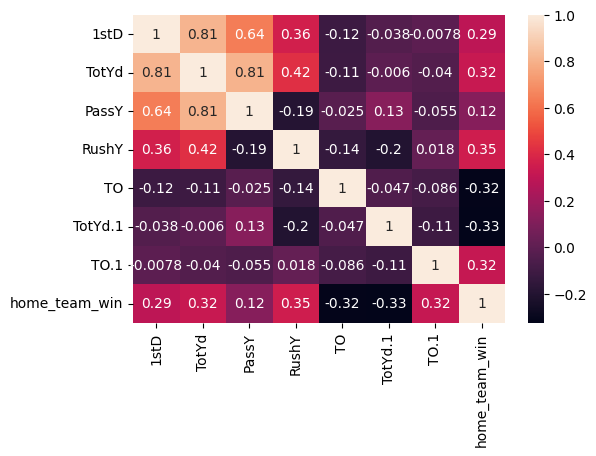

home_team_win    1.000000
RushY            0.349215
TotYd            0.321679
TO.1             0.320323
1stD             0.291832
PassY            0.120321
TO              -0.318914
TotYd.1         -0.325955
Name: home_team_win, dtype: float64


In [99]:
variablesToPlot = predictors + ["home_team_win"]
plt.figure(figsize=(6,4))
sns.heatmap(nfl_data[variablesToPlot].corr(), annot=True)
plt.show()
print(nfl_data[variablesToPlot].corr()["home_team_win"].sort_values(ascending=False))

Rushing yards and limiting turnovers are essential for winning as a home team. 

What is interesting is that getting the other team to turn the ball over matters a little bit more than limiting your team's turnovers. 

# Has passing become more prevalent since 1990s?

Each dataframe contains player passing data from three different years from the 1990s era and the 2020s era, pulled from pfr.com. 

Text(0, 0.5, 'Frequency')

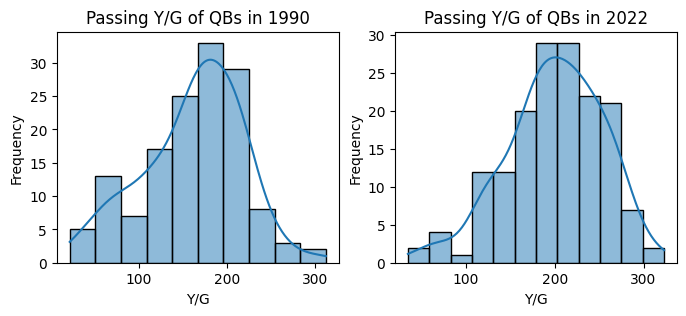

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

passing1990 = pd.read_csv("PlayerStatsPFRData/playerstats1990.csv")
passing1991 = pd.read_csv("PlayerStatsPFRData/playerstats1991.csv")
passing1992 = pd.read_csv("PlayerStatsPFRData/playerstats1992.csv")

passing1990s = pd.concat([passing1990, passing1991, passing1992], ignore_index=True)


passing2022 = pd.read_csv("PlayerStatsPFRData/playerstats2022.csv")
passing2023 = pd.read_csv("PlayerStatsPFRData/playerstats2023.csv")
passing2024 = pd.read_csv("PlayerStatsPFRData/playerstats2024.csv")

passing2020s = pd.concat([passing2022, passing2023, passing2024], ignore_index=True)


sns.histplot(passing1990s[passing1990s["Att"] > 60]["Y/G"], ax=axes[0], kde=True)
sns.histplot(passing2020s[passing2020s["Att"] > 60]["Y/G"], ax=axes[1], kde=True)
axes[0].set_title("Passing Y/G of QBs in 1990")
axes[1].set_title("Passing Y/G of QBs in 2022")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel("Frequency")


**A two sample, one-sided t-test will be conducted using passing yards per game (Y/G) to determine if there is evidence showing that passing has evolved between two different eras.**

**Ho:** The mean passing yards per game (Y/G) for QBs in the 1990s is equal to the mean passing yards per game for QBs in the 2020s.  μ₁ = μ₂

**Ha:** The mean passing yards per game (Y/G) for QBs in the 1990s is less than the mean passing yards per game for QBs in the 2020s.  μ₁ < μ₂


In [20]:
sample1 = passing1990s[passing1990s["Att"] > 50].sample(40, random_state=43819048)
sample2 = passing2020s[passing2020s["Att"] > 50].sample(40, random_state=5012309)


print(sample1["Y/G"].mean())
print(sample2["Y/G"].mean())

tStatistic, pValue = stats.ttest_ind(sample1["Y/G"], sample2["Y/G"], equal_var=False, alternative="less")


print(f"T-Statistic: {tStatistic}")
print(f"p-Value: {pValue}")

156.91000000000003
196.60250000000002
T-Statistic: -3.252398589060368
p-Value: 0.0008557119705283694


The p-value returned by the test is 0.08%, which is less than our significance level of 5%, demonstrating that there is evidence to show that passing has become more prevalent in today's era compared to the 1990s. 

# Fantasy Points Analysis

## Is there a linear correlation between PPR Fantasy Points in a Wide Reciever's rookie year and Combine/Physical Stats?

-0.06435252052317154
-0.2405701951716763
0.1819746283200809
-0.2218740721490704
0.13303026243436744


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     fantasy_points_ppr   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     1.670
Date:                Wed, 13 Aug 2025   Prob (F-statistic):              0.143
Time:                        20:16:59   Log-Likelihood:                -396.90
No. Observations:                  72   AIC:                             807.8
Df Residuals:                      65   BIC:                             823.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            961.9478    501.554      1.918      0.060     -39.724    1963.620
shuttle             -118.9955     88.464     -1.345      0.183    -295.670      57.679
vertical               0.8237      4.385      0.188      0.852      -7.934       9.582
forty               -103.8433     94.075     -1.104      0.274    -291.725      84.038
broad_jump             0.4115      1.895      0.217      0.829      -3.373       4.196
cone                  -6.7373     56.862     -0.118      0.906    -120.298     106.824
shuttle_missing             0          0        nan        nan           0           0
vertical_missing            0          0        nan        nan           0           0
forty_missing               0          0        nan        nan           0           0
broad_jump_missing          0          0        nan        nan           0           0
cone_missing                0          0        nan        nan           0           0
bench                  2.5982      2.206      1.178      0.243      -1.807       7.004
bench_missing               0          0        nan        nan           0           0
==============================================================================
Omnibus:                       10.233   Durbin-Watson:                   0.993
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               11.198
Skew:                           0.966   Prob(JB):                      0.00370
Kurtosis:                       2.970   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

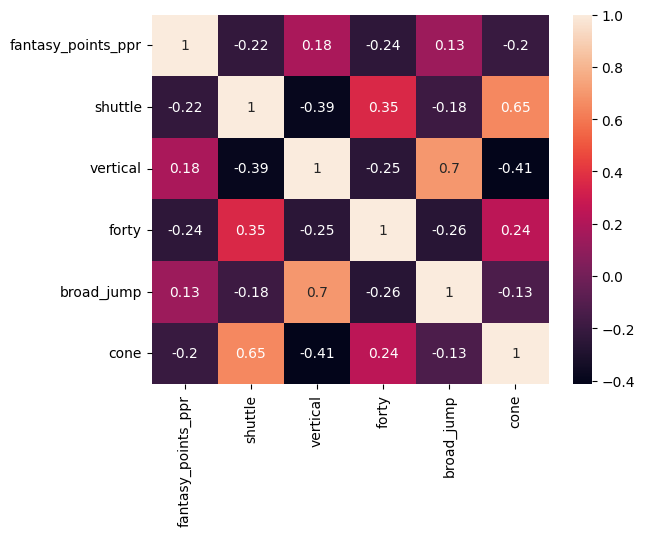

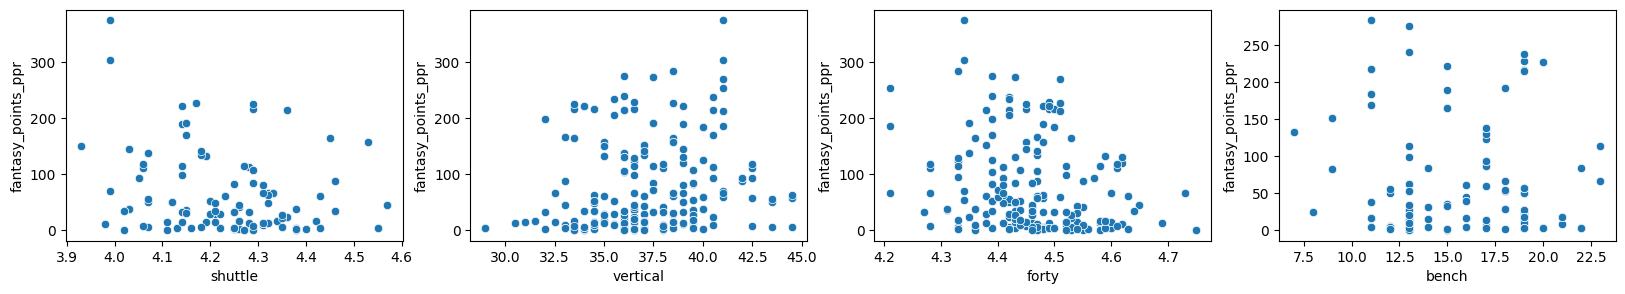

In [48]:
from statsmodels.formula.api import ols

pd.options.mode.chained_assignment = None  

subset = allWrs[["fantasy_points_ppr", "shuttle", "vertical","forty", "broad_jump", "cone"]]
sns.heatmap(subset.corr(), annot=True)


fig, axes = plt.subplots(1, 4, figsize=(20,3))
sns.scatterplot(data=allWrs, x="shuttle", y="fantasy_points_ppr", ax=axes[0])
sns.scatterplot(data=allWrs, x="vertical", y="fantasy_points_ppr", ax=axes[1])
sns.scatterplot(data=allWrs, x="forty", y="fantasy_points_ppr", ax=axes[2])
sns.scatterplot(data=allWrs, x="bench", y="fantasy_points_ppr", ax=axes[3])

print(allWrs["fantasy_points_ppr"].corr(allWrs["bench"]))
print(allWrs["fantasy_points_ppr"].corr(allWrs["forty"]))
print(allWrs["fantasy_points_ppr"].corr(allWrs["vertical"]))
print(allWrs["fantasy_points_ppr"].corr(allWrs["shuttle"]))
print(allWrs["fantasy_points_ppr"].corr(allWrs["broad_jump"]))

OLS = ols(
    formula="fantasy_points_ppr ~ shuttle + vertical + forty + broad_jump + cone + shuttle_missing + vertical_missing + forty_missing + broad_jump_missing + cone_missing + bench + bench_missing",
    data=allWrs
)
model = OLS.fit()
model.summary()

Clearly, there is little to no correlation for WRs for combine statistics. However, there is an issue of multicollinearity, since most likely if someone excels at the forty, they will most likely excel at the shuttle.

Additionally, this colinearity extends to the "missing variables," since they have 0 for coefficients for all of them. This is because the model is able to predict what the value of the missing column is. 

In [114]:
ints = allWrs.select_dtypes(include=["Int16", "Int32", "Float32", "Float64"])
ints.corr()["fantasy_points_ppr"].sort_values(ascending=False)

fantasy_points_ppr         1.000000
fantasy_points             0.994286
receiving_yards            0.988479
receiving_first_downs      0.982267
receptions                 0.977564
                             ...   
passing_tds                     NaN
sack_fumbles                    NaN
sack_fumbles_lost               NaN
passing_2pt_conversions         NaN
dakota                          NaN
Name: fantasy_points_ppr, Length: 64, dtype: float64